In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# 1- Loading data and basic EDA

    age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0    63    1   3       145   233    1        0      150      0      2.3   
1    37    1   2       130   250    0        1      187      0      3.5   
2    41    0   1       130   204    0        0      172      0      1.4   
3    56    1   1       120   236    0        1      178      0      0.8   
4    57    0   0       120   354    0        1      163      1      0.6   
5    57    1   0       140   192    0        1      148      0      0.4   
6    56    0   1       140   294    0        0      153      0      1.3   
7    44    1   1       120   263    0        1      173      0      0.0   
8    52    1   2       172   199    1        1      162      0      0.5   
9    57    1   2       150   168    0        1      174      0      1.6   
10   54    1   0       140   239    0        1      160      0      1.2   
11   48    0   2       130   275    0        1      139      0      0.2   
12   49    1   1       13

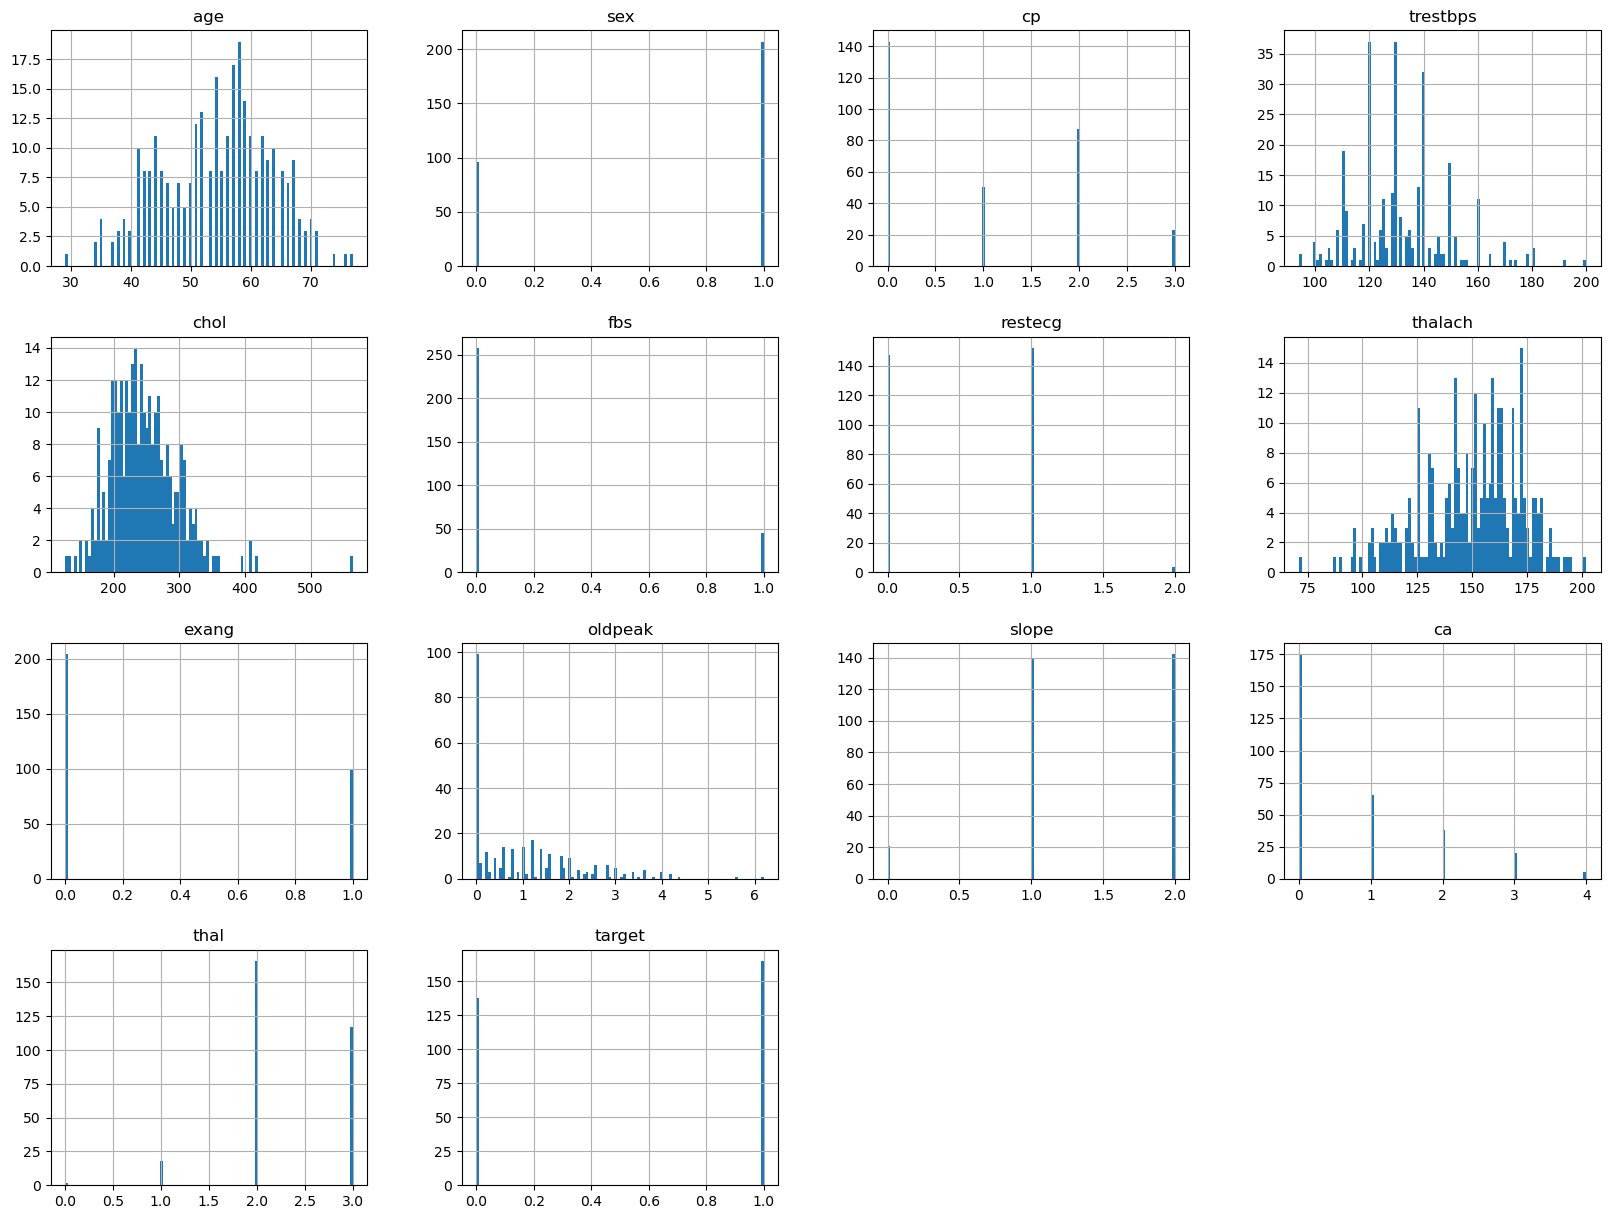

In [23]:
# Load the data from the CSV file
df = pd.read_csv(r'D:\Other\1- Masters Data\1- ML Course\Assignments\Assignment 4\heart.csv')
print(df.head(20), '\n')

# Checking insights of the data (the whole dataset is numerical)
print('\n',df.describe(), '\n')
print('\n',df.info(), '\n')

# histogram of the data
df.hist(bins= 100, figsize=(20, 15))
plt.show()



,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,63,1,145,233,1,0,150,0,2,0,...,0,0,1,0,1,0,0,1,0,0
1,37,1,130,250,0,1,187,0,3,0,...,0,1,0,0,0,1,0,1,0,0
2,41,0,130,204,0,0,172,0,1,0,...,1,0,0,0,0,1,0,0,0,1
3,56,1,120,236,0,1,178,0,0,0,...,1,0,0,0,0,1,0,0,0,1
4,57,0,120,354,0,1,163,1,0,0,...,0,0,0,0,0,1,0,0,0,1


# 2- Preprocessing step

a- Handling Null Values

b- removing highly correlated features to avoid multi-collinearity as much as we can

c- removing/clamping outliers


In [15]:
# a- Function to handle missing values
def handle_missing_values(df):
    print("Missing values per column:\n", df.isnull().sum())
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
    return df

# b- Function to identify and exclude redundant features
def reduce_features(df, target_col, threshold=0.7):
    numeric_df = df.select_dtypes(include=[np.number])
    if target_col not in numeric_df.columns:
        raise ValueError(f"Target column '{target_col}' not found or is not numeric.")
    
    corr_matrix = numeric_df.corr()
    plt.figure(figsize=(10, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.show()
    
    num_cols_without_response = [col for col in numeric_df.columns if col != target_col]
    target_corr = {col: np.abs(numeric_df[col].corr(numeric_df[target_col])) for col in num_cols_without_response}
    redundant_features = set()
    
    for row_idx, row_feature in enumerate(num_cols_without_response):
        for col_idx, col_feature in enumerate(num_cols_without_response[row_idx + 1:], start=row_idx + 1):
            if np.abs(corr_matrix.loc[row_feature, col_feature]) > threshold:
                if target_corr[row_feature] > target_corr[col_feature]:
                    redundant_features.add(col_feature)
                else:
                    redundant_features.add(row_feature)
    
    final_features = [col for col in num_cols_without_response if col not in redundant_features]
    print("Final numeric features:", final_features, "\n")
    
    # Combine final numeric features with other non-numeric columns and target column
    non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns
    final_features.extend(non_numeric_cols)
    if target_col not in final_features:
        final_features.append(target_col)
    
    # Return the DataFrame with only the selected features
    return df[final_features]

# c- Function to clamp outliers
def clamp_outliers(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        if IQR == 0:
            continue  # Skip clamping for constant columns
        upper_bound = Q3 + 1.5 * IQR
        lower_bound = Q1 - 1.5 * IQR
        df[col] = df[col].apply(lambda x: min(max(x, lower_bound), upper_bound))
    return df

Missing values per column:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


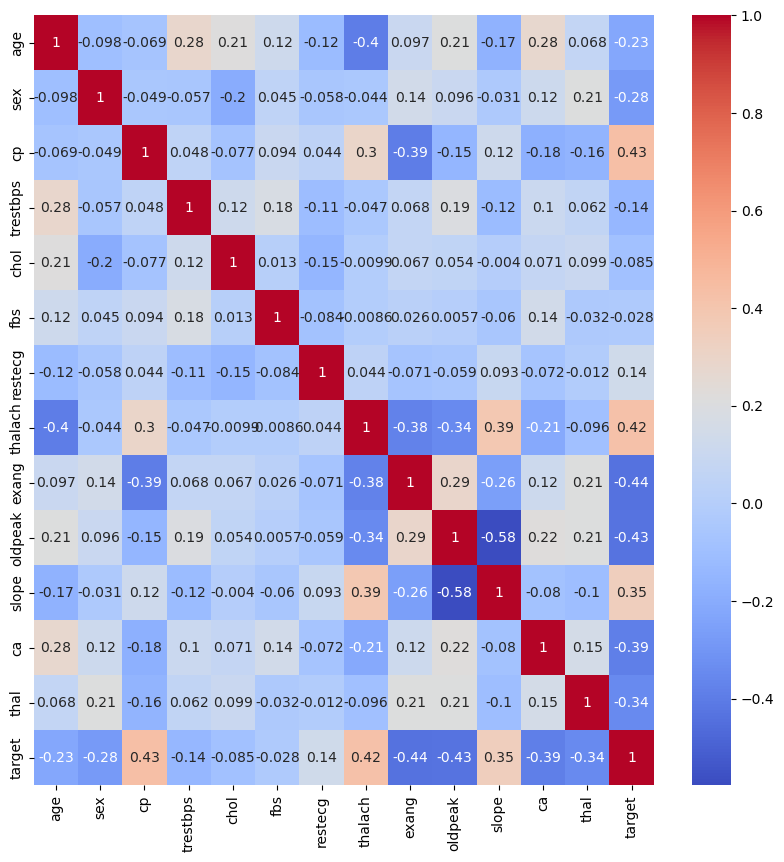

Final numeric features: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal'] 



In [24]:
df_copy = handle_missing_values(df)
df_copy = reduce_features(df_copy, 'target')
df_copy = clamp_outliers(df_copy)

# 3- Feature Engineering

age        -0.202463
trestbps    0.386367
chol        0.333267
thalach    -0.493392
oldpeak     0.997885
dtype: float64


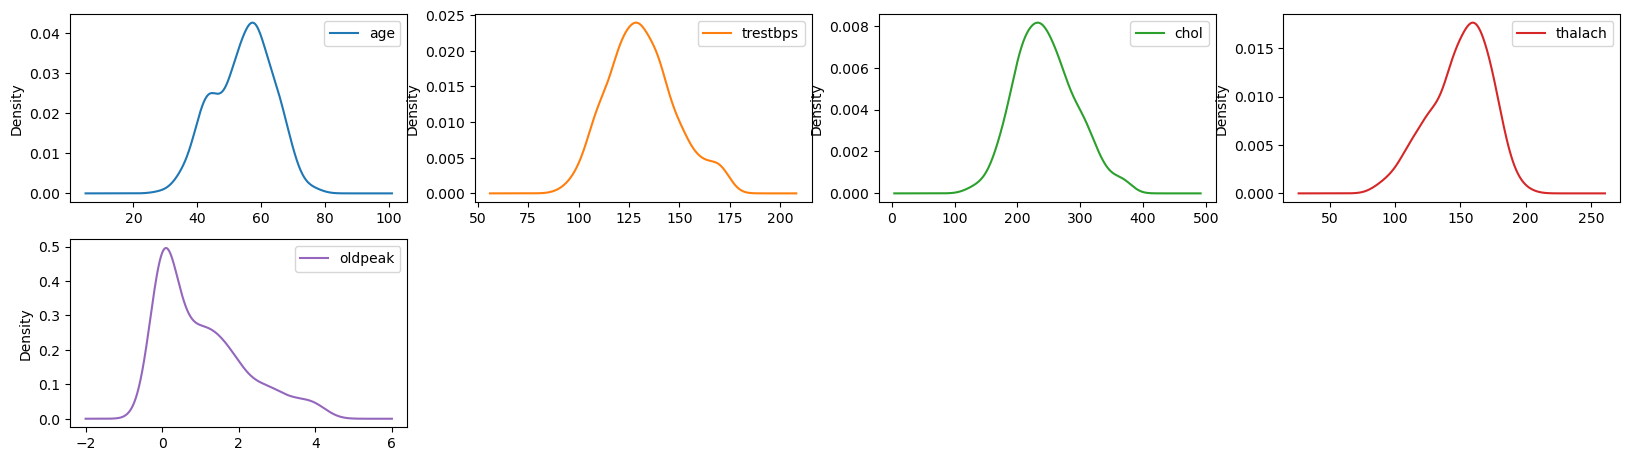

age        -0.576101
trestbps    0.070880
chol       -0.210333
thalach    -0.877936
oldpeak     0.346115
dtype: float64


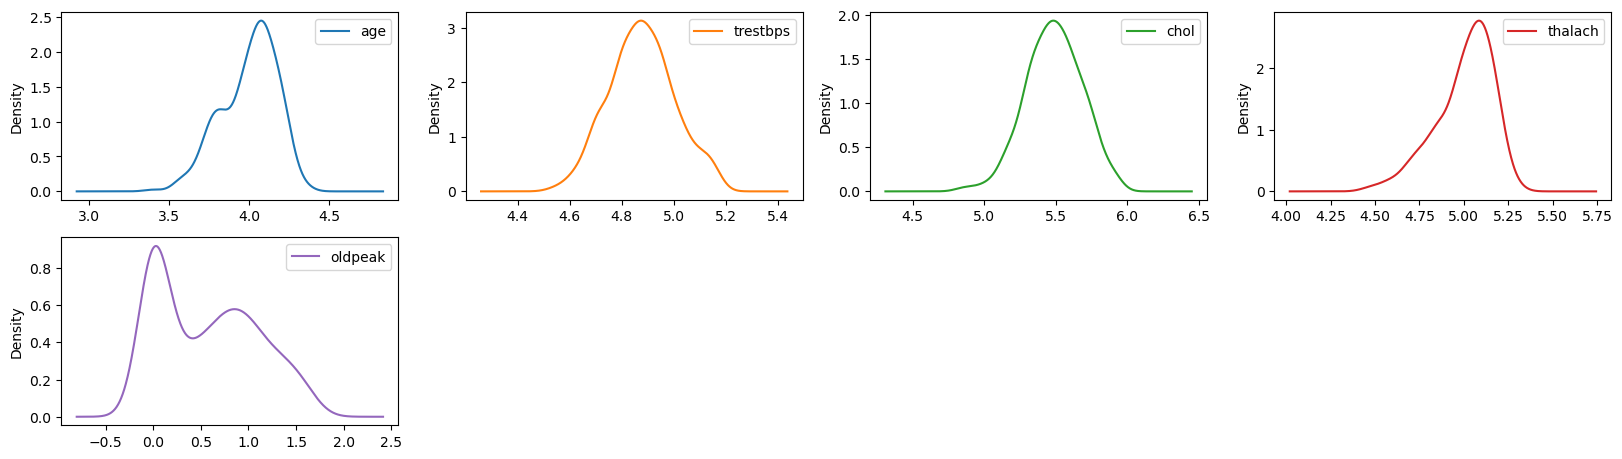


 
 New Statistis after feature transformations :

               age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean     3.999769    0.683168    0.966997    4.877180    5.487094    0.148515   
std      0.171671    0.466011    1.032052    0.124503    0.195477    0.356198   
min      3.401197    0.000000    0.000000    4.553877    4.844187    0.000000   
25%      3.881511    0.000000    0.000000    4.795791    5.356586    0.000000   
50%      4.025352    1.000000    1.000000    4.875197    5.484797    0.000000   
75%      4.127134    1.000000    2.000000    4.948760    5.618586    0.000000   
max      4.356709    1.000000    3.000000    5.141664    5.915528    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean     0.528053    5.002874    0.326733    0.567311   

In [25]:
## 1- Feature Transformation (to continuous variables using log transformation)

# Before transformation
print(df_copy[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']].skew())
df_copy[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']].plot(kind='density',subplots=True,layout=(7,4),figsize=(20,20),sharex=False)
plt.show()
# Log Transformation for Feature Engineering
df_copy[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']]= np.log(1 + df_copy[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']])
print(df_copy[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']].skew())

# After transformation
df_copy[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']].plot(kind='density',subplots=True,layout=(7,4),figsize=(20,20),sharex=False)
plt.show()

print(f'\n \n New Statistis after feature transformations :\n\n {df_copy.describe()}\n')

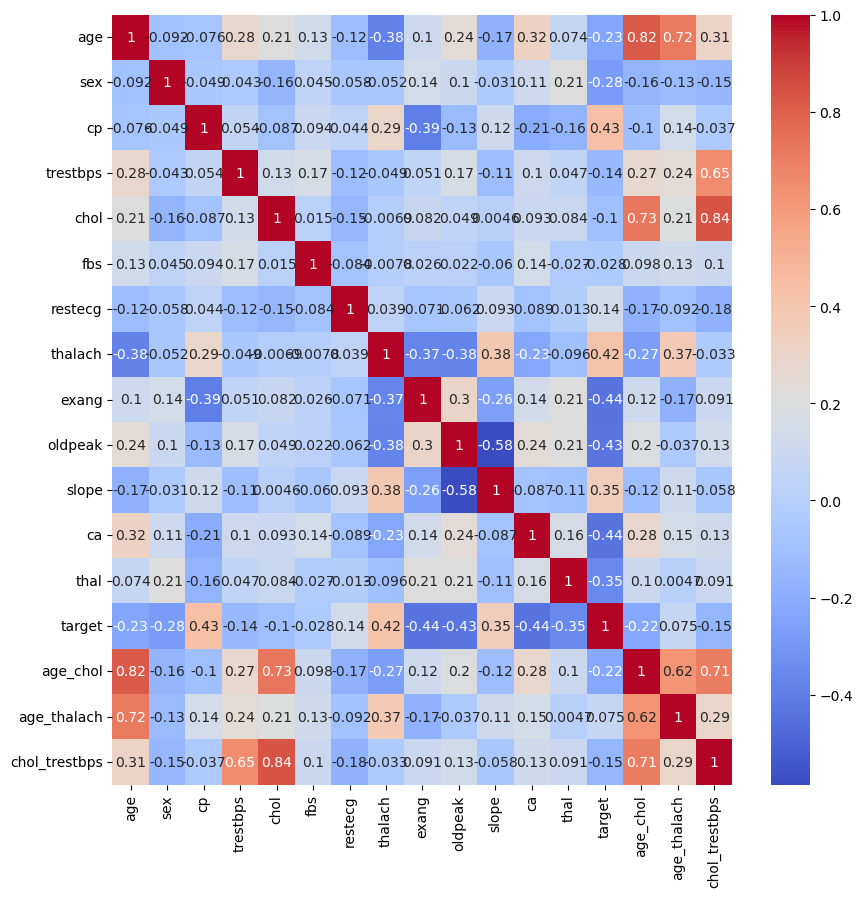

Final numeric features: ['age', 'sex', 'cp', 'trestbps', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal'] 



,age,sex,cp,trestbps,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,4.158883,1,3,4.983607,1,0,5.017280,0,1.193922,0,0.0,1.0,1
1,3.637586,1,2,4.875197,0,1,5.236442,0,1.504077,0,0.0,2.0,1
2,3.737670,0,1,4.875197,0,0,5.153292,0,0.875469,2,0.0,2.0,1
3,4.043051,1,1,4.795791,0,1,5.187386,0,0.587787,2,0.0,2.0,1
4,4.060443,0,0,4.795791,0,1,5.099866,1,0.470004,2,0.0,2.0,1


In [26]:
## 2- Feature Creation
# Creating new feature
df_copy['age_chol'] = df_copy['age'] * df_copy['chol']
df_copy['age_thalach'] = df_copy['age'] * df_copy['thalach']
df_copy['chol_trestbps'] = df_copy['chol'] * df_copy['trestbps']

# check after if new features are redundant to remove them
df_final = reduce_features(df_copy, 'target', threshold=0.7) # features are redundant
df_final.head()

# 4- Model Implementation

## 1. Logistic Regression

### a.Logistic Regression (From Scratch)

In [27]:
def sigmoid(x):
    """
    Computes the sigmoid (logistic) function for the input values.
    
    The sigmoid function is defined as 1 / (1 + exp(-x)), and is commonly used in 
    logistic regression and neural networks to map input values to a range between 0 and 1.
    
    Parameters:
    x : ndarray or scalar
        Input value(s) for which to compute the sigmoid function.
    
    Returns:
    ndarray or scalar
        The computed sigmoid of each input value.
    """
    return 1 / (1 + np.exp(-x))

### b. Loss Function

In [28]:
#### b.1 Loss function (without regularization)
def compute_loss_wzt_regularization(X, y, W):
    """
    Computes the logistic regression loss without regularization (binary cross-entropy).
    
    Parameters:
    X : ndarray
        Feature matrix (with bias column).
    y : ndarray
        True binary labels (0 or 1).
    W : ndarray
        Model parameters (weights and bias).
    
    Returns:
    float
        The computed loss (binary cross-entropy).
    """
    h = sigmoid(X @ W)
    epsilon = 1e-5 # Prevent log(0)
    loss = (((-y).T @ np.log(h + epsilon))-((1-y).T @ np.log(1-h + epsilon)))
    return loss


#### b.2 Loss function (with ridge regularization)
def compute_loss_with_regularization(X, y, W, lambdaa):
    """
    Computes the logistic regression loss with L2 (ridge) regularization.
    
    Parameters:
    X : ndarray
        Feature matrix with a bias column.
    y : ndarray
        True labels (0 or 1).
    W : ndarray
        Model parameters (weights and bias).
    lambdaa : float
        Regularization parameter controlling the strength of the penalty.
    
    Returns:
    float
        The loss value with L2 regularization.
    """
    h = sigmoid(X @ W)
    loss = compute_loss_wzt_regularization(X, y, W)
    reg_term = lambdaa * np.sum(W[1:]**2)  # Exclude bias term
    total_loss = loss + reg_term
    return total_loss

### c. Gradient descent optimization

In [29]:
def gradient_descent(X, y, params, learning_rate, iterations):
    """
    Performs gradient descent optimization to minimize the loss function for logistic regression.

    Parameters:
    X : ndarray
        Feature matrix with input data (including bias term).
    y : ndarray
        True labels (target variable).
    params : ndarray
        Initial model parameters (weights and bias).
    learning_rate : float
        Step size for each update to the model parameters.
    iterations : int
        Number of iterations to run the gradient descent.

    Returns:
    - loss_history (ndarray): 
        Array of loss values for each iteration.
    - params (ndarray): 
        Final model parameters (weights and bias) after optimization.
    """
    m = len(y)
    loss_history = np.zeros((iterations, 1))
    for i in range(iterations):
        params = params - (learning_rate / m) * (X.T @ (sigmoid(X @ params) - y))
        loss_history[i] = compute_loss_wzt_regularization(X, y, params)
    return loss_history, params

### d. L1 (Lasso) and L2 (Ridge) regularization options

In [30]:
## Loss function (with L1 and L2 regularization)
def compute_loss_with_L1_L2(X, y, W, L1, L2):
    """
    Computes the logistic regression loss with L1 and L2 regularization.

    Parameters:
    X : ndarray
        Feature matrix, where each row is a sample and each column is a feature.
    y : ndarray
        Target vector (true labels).
    W : ndarray
        Model parameters (weights), including the bias term.
    L1 : float
        Regularization strength for L1 regularization (Lasso).
    L2 : float
        Regularization strength for L2 regularization (Ridge).

    Returns:
    float
        The computed loss, which includes both logistic loss and regularization terms.
    """
    loss = compute_loss_wzt_regularization(X, y, W)
    l1_reg = L1 * np.sum(W[1:]**2)
    l2_reg = L2 * np.sum(np.abs(W[1:]))
    return loss + l1_reg + l2_reg


def gradient_descent_L1_L2(X, y, params, learning_rate, iterations, L1, L2):
    """
    Performs gradient descent with L1 (Lasso) and L2 (Ridge) regularization for logistic regression.

    Parameters:
    X : ndarray
        Feature matrix with a bias column.
    y : ndarray
        Target vector (binary outcomes).
    params : ndarray
        Initial model parameters (weights and bias).
    learning_rate : float
        The learning rate used to update the parameters.
    iterations : int
        The number of iterations for gradient descent.
    L1 : float
        The regularization strength for L1 (Lasso).
    L2 : float
        The regularization strength for L2 (Ridge).

    Returns:
    loss_history : ndarray
        History of loss values across iterations.
    params : ndarray
        Optimized model parameters after training.
    """
    m = len(y)
    loss_history = np.zeros((iterations,1))
    for i in range(iterations):
        gradient = (X.T @ (sigmoid(X @ params) - y)) / m
        gradient[1:] += (L1 * np.sign(params[1:]) + L2 * params[1:]) / m
        params -= learning_rate * gradient
        loss_history[i] = compute_loss_with_L1_L2(X, y, params, L1, L2)
    return loss_history, params

### e. Prediction and evaluation

#### e.1 Prediction

In [31]:
def predict(X, params):
    """
    Predicts binary outcomes (0 or 1) using logistic regression.
    
    Parameters:
    X : ndarray
        Feature matrix with a bias column.
    params : ndarray
        Model parameters (weights and bias).
    
    Returns:
    ndarray
        Binary predictions (0 or 1).
    """
    return np.round(sigmoid(X @ params))

# training data setup
X = df_final.drop('target', axis=1).values
y = df_final['target'].values.reshape(-1, 1)
X = np.c_[np.ones((X.shape[0], 1)), X]  # Add bias term

# Initialize parameters
params = np.zeros((X.shape[1], 1)) # to start the training process. Initially setting all parameters to zero
learning_rate = 0.001
iterations = 100000

# Train and Predictions logistic regression without regularization
loss_history, trained_params = gradient_descent(X, y, params, learning_rate, iterations)
predictions1 = predict(X, trained_params)
print(f" \n \n Checking predictions incase using logistic regresion without regularization:-\n \n ")
print("Predictions:", predictions1.flatten(),"\n \n")
print("Final Loss:", loss_history[-1], "\n \n")

# Train and Predictions logistic regression with ridge and lasso regularization
L1 = 0.01
L2 = 0.01
loss_history_L1_L2, trained_params_L1_L2 = gradient_descent_L1_L2(X, y, params, learning_rate, iterations, L1, L2)
predictions2 = predict(X, trained_params_L1_L2)
print(f" \n \n Checking predictions incase using logistic regresion with L1 and L2 regularization:-\n \n ")
print("Predictions:", predictions2.flatten(), "\n \n")
print("Final Loss:", loss_history_L1_L2[-1],"\n \n")

 
 
 Checking predictions incase using logistic regresion without regularization:-
 
 
Predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0.
 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 1. 0. 0.

#### e.2 Data Split (training, testing) to see effect of regularization

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and Predictions logistic regression without regularization
loss_history, trained_params = gradient_descent(X_train, y_train, params, learning_rate, iterations)
predictions1 = predict(X_test, trained_params)
print(f" \n \n Checking predictions incase using logistic regresion without regularization:-\n \n ")
print("Predictions:", predictions1.flatten(),"\n \n")
print("Final Loss:", loss_history[-1], "\n \n")

# Train and Predictions logistic regression with ridge and lasso regularization
L1 = 0.01
L2 = 0.001
loss_history_L1_L2, trained_params_L1_L2 = gradient_descent_L1_L2(X_train, y_train, params, learning_rate, iterations, L1, L2)
predicted = predict(X_test, trained_params_L1_L2)
print(f" \n \n Checking predictions incase using logistic regresion with L1 and L2 regularization:-\n \n ")
print("Predictions:", predictions2.flatten(), "\n \n")
print("Final Loss:", loss_history_L1_L2[-1],"\n \n")

 
 
 Checking predictions incase using logistic regresion without regularization:-
 
 
Predictions: [0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1.
 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.] 
 

Final Loss: [83.88764357] 
 

 
 
 Checking predictions incase using logistic regresion with L1 and L2 regularization:-
 
 
Predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0.
 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 

#### e.3 Evaluation

In [33]:
def compute_confusion_matrix(y_true, y_pred):
    """
    Computes the confusion matrix elements for binary classification.
    
    Parameters:
    - y_true: Actual class labels (array-like, binary: 0 or 1).
    - y_pred: Predicted class labels (array-like, binary: 0 or 1).
    
    Returns:
    - TP: True Positives - Cases where both actual and predicted are 1.
    - TN: True Negatives - Cases where both actual and predicted are 0.
    - FP: False Positives - Cases where actual is 0 but predicted is 1.
    - FN: False Negatives - Cases where actual is 1 but predicted is 0.
    """
    TP = ((y_true == 1) & (y_pred == 1)).sum()
    TN = ((y_true == 0) & (y_pred == 0)).sum()
    FP = ((y_true == 0) & (y_pred == 1)).sum() # fp refers to the prediction of the model positive, but the actual value is negative.
    FN = ((y_true == 1) & (y_pred == 0)).sum() # fn refers to the prediction of the model negative, but the actual value is positive.
    return TP, TN, FP, FN

def compute_metrics(y_true, y_pred):
    """
    Computes evaluation metrics for binary classification based on the confusion matrix.
    
    Parameters:
    - y_true: Actual class labels (array-like, binary: 0 or 1).
    - y_pred: Predicted class labels (array-like, binary: 0 or 1).
    
    Returns:
    - accuracy: Overall accuracy of the predictions.
    - precision: Measure of positive predictions' correctness (TP / (TP + FP)).
    - recall: Measure of capturing all actual positives (TP / (TP + FN)).
    - f1_score: Harmonic mean of precision and recall.
    """
    TP, TN, FP, FN = compute_confusion_matrix(y_true, y_pred)
    
    # Compute metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN) # all of true values over all of values (true and false)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0  # how precise the model is when it predicts the positive class.
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0 # Recall (sensitivity) measures the proportion of actual positives correctly identified by the model.
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return accuracy, precision, recall, f1_score
def compute_roc_auc(y_true, y_probs, num_thresholds=100):
    """
    Computes the ROC-AUC score for binary classification.

    Parameters:
    - y_true: Actual class labels (array-like, binary: 0 or 1).
    - y_probs: Predicted probabilities for the positive class (array-like, floats).
    - num_thresholds: Number of thresholds to consider between 0 and 1.

    Returns:
    - auc: The area under the ROC curve (float).
    """
    thresholds = np.linspace(0, 1, num_thresholds)
    tpr_list = []  # True Positive Rates
    fpr_list = []  # False Positive Rates

    for threshold in thresholds:
        # Convert probabilities to binary predictions based on the threshold
        y_pred = (y_probs >= threshold).astype(int)

        # Compute confusion matrix components
        TP, TN, FP, FN = compute_confusion_matrix(y_true, y_pred)
        
        # Calculate TPR and FPR
        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
        
        tpr_list.append(TPR)
        fpr_list.append(FPR)

    # Sort FPR and TPR pairs
    sorted_indices = np.argsort(fpr_list)
    fpr_list = np.array(fpr_list)[sorted_indices]
    tpr_list = np.array(tpr_list)[sorted_indices]

    # Compute AUC using the trapezoidal rule
    auc = np.trapz(tpr_list, fpr_list)
    return auc


# Predictions and true labels (example: replace with actual predictions)
y_true = y_test.flatten()
y_pred = predicted.flatten()  # using predictions from regularized model

# Compute metrics
accuracy, precision, recall, f1_score = compute_metrics(y_true, y_pred)
y_probs = sigmoid(X_test @ trained_params_L1_L2).flatten()
roc_auc = compute_roc_auc(y_true, y_probs)

# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")
print(f"ROC-AUC Score: {roc_auc}")
compute_confusion_matrix(y_true, y_pred)

Accuracy: 0.8688524590163934
Precision: 0.875
Recall: 0.875
F1 Score: 0.875
ROC-AUC Score: 0.9191810344827587


(28, 25, 4, 4)

## 2. k-Nearest Neighbors (KNN)

### a. k-Nearest Neighbors predictions

In [65]:
def knn_predictions(X_train, y_train, X_test, y_test, k_values=[3, 10], metrics=['euclidean', 'manhattan']):
    """
    Perform K-Nearest Neighbors classification with specified k-values and distance metrics, 
    and print predictions.

    Parameters:
    - X_train: Training data features.
    - y_train: Training data labels.
    - X_test: Test data features.
    - y_test: Test data labels.
    - k_values: List of k-values (number of neighbors) to test.
    - metrics: List of distance metrics to test (e.g., 'euclidean', 'manhattan').

    Returns:
    - None, but prints predictions for each combination of k-value and metric.
    """
    
    # Ensure y_train and y_test are 1D arrays
    y_train = y_train.ravel()
    y_test = y_test.ravel()
    
    for metric in metrics:
        for k in k_values:
            # Initialize and fit KNeighborsClassifier with the given metric and k
            knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
            knn.fit(X_train, y_train)
            
            # Make predictions and probabilities
            y_pred = knn.predict(X_test)
            y_proba = knn.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
            
            print(f"Predictions if {metric.capitalize()}, and kk = {k} :\n {y_pred}\n\n")
# Example usage:
knn_predictions(X_train, y_train, X_test, y_test)

Predictions if Euclidean, and kk = 3 :
 [0 1 1 0 1 1 0 0 0 1 1 0 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 0 0 0 0 1 0 0
 1 0 1 1 1 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0]


Predictions if Euclidean, and kk = 10 :
 [0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 0 0 0 0 1 0 0
 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0]


Predictions if Manhattan, and kk = 3 :
 [0 1 1 0 1 1 0 0 0 1 1 0 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 0 0 0 0 1 0 0
 1 0 1 1 1 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0]


Predictions if Manhattan, and kk = 10 :
 [0 1 1 0 1 1 0 0 0 1 1 0 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 0 0 0 0 1 0 0
 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0]




### b. Compute Metrics for KNN

In [52]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def evaluate_knn_model(X_train, X_test, y_train, y_test, distance_metric, k_values=[3, 10]):
    """
    Evaluates K-Nearest Neighbors (KNN) classification with different distance metrics and k values.
    
    Parameters:
    - X_train: Training feature set.
    - X_test: Testing feature set.
    - y_train: Training labels.
    - y_test: Testing labels.
    - distance_metric: 'euclidean' or 'manhattan' to choose the distance metric.
    - k_values: List of k values to evaluate for KNN.
    
    Returns:
    - None
    """
    # Ensure y_train and y_test are 1D arrays
    y_train = y_train.ravel()
    y_test = y_test.ravel()
    
    for k in k_values:
        # Initialize and fit the KNN classifier with the specified distance metric and k value
        knn = KNeighborsClassifier(n_neighbors=k, metric=distance_metric)
        knn.fit(X_train, y_train)
        
        # Predict labels and probabilities
        y_pred = knn.predict(X_test)
        y_proba = knn.predict_proba(X_test)[:, 1]
        
        # Compute evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)
        
        # Print results for this k and distance metric
        print(f"{distance_metric.capitalize()} Distance, k = {k}:\n")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1-Score: {f1}")
        print(f"Confusion Matrix:\n{cm}")
        print(f"AUC: {auc}\n\n")

# Example usage
evaluate_knn_model(X_train, X_test, y_train, y_test, distance_metric='euclidean', k_values=[3, 10])
evaluate_knn_model(X_train, X_test, y_train, y_test, distance_metric='manhattan', k_values=[3, 10])

Euclidean Distance, k = 3:

Accuracy: 0.819672131147541
Precision: 0.8620689655172413
Recall: 0.78125
F1-Score: 0.8196721311475409
Confusion Matrix:
[[25  4]
 [ 7 25]]
AUC: 0.8539870689655172


Euclidean Distance, k = 10:

Accuracy: 0.8524590163934426
Precision: 0.8709677419354839
Recall: 0.84375
F1-Score: 0.8571428571428571
Confusion Matrix:
[[25  4]
 [ 5 27]]
AUC: 0.9202586206896552


Manhattan Distance, k = 3:

Accuracy: 0.819672131147541
Precision: 0.8620689655172413
Recall: 0.78125
F1-Score: 0.8196721311475409
Confusion Matrix:
[[25  4]
 [ 7 25]]
AUC: 0.8582974137931034


Manhattan Distance, k = 10:

Accuracy: 0.8524590163934426
Precision: 0.8709677419354839
Recall: 0.84375
F1-Score: 0.8571428571428571
Confusion Matrix:
[[25  4]
 [ 5 27]]
AUC: 0.9137931034482759




## 3. Support Vector Machines (SVM)

### a. Support Vector Machines (SVM) prediction

In [50]:
def svm_predictions(X_train, y_train, X_test, y_test, C_values=[1, 10], kernels=['rbf', 'linear', 'poly']):
    """
    Perform Support Vector Machine (SVM) classification with specified C values and kernel types,
    and print predictions.

    Parameters:
    - X_train: Training data features.
    - y_train: Training data labels.
    - X_test: Test data features.
    - y_test: Test data labels.
    - C_values: List of regularization parameters C to test.
    - kernels: List of kernel types to test (e.g., 'rbf', 'linear', 'poly').

    Returns:
    - None, but prints predictions for each combination of kernel and C-value.
    """
    
    # Ensure y_train and y_test are 1D arrays
    y_train = y_train.ravel()
    y_test = y_test.ravel()
    
    for kernel in kernels:
        for C in C_values:
            # Initialize and fit SVM classifier with the given kernel and C
            svm = SVC(kernel=kernel, C=C)
            svm.fit(X_train, y_train)
            
            # Make predictions
            y_pred = svm.predict(X_test)
            
            print(f"Predictions if {kernel.capitalize()} kernel, and C = {C} :\n {y_pred}\n\n")

# Example usage:
svm_predictions(X_train, y_train, X_test, y_test)

Predictions if Rbf kernel, and C = 1 :
 [0 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 0 0 0 0 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0]


Predictions if Rbf kernel, and C = 10 :
 [0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0 0 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0]


Predictions if Linear kernel, and C = 1 :
 [0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0 0 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0]


Predictions if Linear kernel, and C = 10 :
 [0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 1 0 0 0 0 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0]


Predictions if Poly kernel, and C = 1 :
 [0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 0 0 0 0 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0]


Predictions if Poly kernel, and C = 10 :
 [0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0 0 1 1 0 1 1 0 1 0 0 0 0 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 1 1 0 0 

### b. Compute Metrics for SVM

In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def evaluate_svm_model(X_train, X_test, y_train, y_test, kernel_types=['rbf', 'linear', 'poly'], C_values=[1.0, 10.0]):
    """
    Evaluates Support Vector Machine (SVM) classification with different kernel types and C values.
    
    Parameters:
    - X_train: Training feature set.
    - X_test: Testing feature set.
    - y_train: Training labels.
    - y_test: Testing labels.
    - kernel_types: List of kernel types ('linear', 'rbf', etc.) to evaluate.
    - C_values: List of C values to evaluate for SVM.
    
    Returns:
    - None
    """
    # Ensure y_train and y_test are 1D arrays
    y_train = y_train.ravel()
    y_test = y_test.ravel()
    
    for kernel in kernel_types:
        for C in C_values:
            # Initialize and fit the SVM classifier with the specified kernel and C value
            svm = SVC(kernel=kernel, C=C, probability=True)
            svm.fit(X_train, y_train)
            
            # Predict labels and probabilities
            y_pred = svm.predict(X_test)
            y_proba = svm.predict_proba(X_test)[:, 1]
            
            # Compute evaluation metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            cm = confusion_matrix(y_test, y_pred)
            auc = roc_auc_score(y_test, y_proba)
            
            # Print results for this kernel and C value
            print(f"SVM with kernel = {kernel}, C = {C}:\n")
            print(f"Accuracy: {accuracy}")
            print(f"Precision: {precision}")
            print(f"Recall: {recall}")
            print(f"F1-Score: {f1}")
            print(f"Confusion Matrix:\n{cm}")
            print(f"AUC: {auc}\n\n")

# Example usage
evaluate_svm_model(X_train, X_test, y_train, y_test, kernel_types=['rbf', 'linear', 'poly'], C_values=[1.0, 10.0, 100, 1000])

SVM with kernel = rbf, C = 1.0:

Accuracy: 0.8852459016393442
Precision: 0.8571428571428571
Recall: 0.9375
F1-Score: 0.8955223880597014
Confusion Matrix:
[[24  5]
 [ 2 30]]
AUC: 0.9170258620689655


SVM with kernel = rbf, C = 10.0:

Accuracy: 0.8688524590163934
Precision: 0.875
Recall: 0.875
F1-Score: 0.875
Confusion Matrix:
[[25  4]
 [ 4 28]]
AUC: 0.9234913793103448


SVM with kernel = rbf, C = 100:

Accuracy: 0.8688524590163934
Precision: 0.875
Recall: 0.875
F1-Score: 0.875
Confusion Matrix:
[[25  4]
 [ 4 28]]
AUC: 0.9202586206896552


SVM with kernel = rbf, C = 1000:

Accuracy: 0.8688524590163934
Precision: 0.9
Recall: 0.84375
F1-Score: 0.870967741935484
Confusion Matrix:
[[26  3]
 [ 5 27]]
AUC: 0.915948275862069


SVM with kernel = linear, C = 1.0:

Accuracy: 0.8688524590163934
Precision: 0.875
Recall: 0.875
F1-Score: 0.875
Confusion Matrix:
[[25  4]
 [ 4 28]]
AUC: 0.9267241379310345


SVM with kernel = linear, C = 10.0:

Accuracy: 0.8524590163934426
Precision: 0.8709677419354839
R

## k-fold Cross-Validation

In [66]:
def evaluate_model_with_cross_validation(model, X_train, y_train, cv=5, scoring='accuracy'):
    """
    Evaluates the provided model using cross-validation.

    Parameters:
    - model: The machine learning model to evaluate (e.g., SVM, RandomForest).
    - X_train: Training feature set.
    - y_train: Training labels.
    - cv: Number of cross-validation folds (default is 5).
    - scoring: Metric to evaluate ('accuracy' by default).

    Returns:
    - None
    """
    # Perform cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
    
    # Print the average score across all folds
    print(f"Average {scoring.capitalize()} across {cv}-fold cross-validation: {np.mean(scores)}")

## Check for example the below
# 1. Test for KNN (K-Nearest Neighbors)
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')

print("KNN Model - 5-fold Cross-Validation:")
evaluate_model_with_cross_validation(knn, X_train, y_train, cv=5, scoring='accuracy')

print("\nKNN Model - 10-fold Cross-Validation:")
evaluate_model_with_cross_validation(knn, X_train, y_train, cv=10, scoring='accuracy')

# 2. Test for SVM (Support Vector Machine)
svm = SVC(kernel='rbf', C=1)

print("\nSVM Model - 5-fold Cross-Validation:")
evaluate_model_with_cross_validation(svm, X_train, y_train, cv=5, scoring='accuracy')

print("\nSVM Model - 10-fold Cross-Validation:")
evaluate_model_with_cross_validation(svm, X_train, y_train, cv=10, scoring='accuracy')

KNN Model - 5-fold Cross-Validation:
Average Accuracy across 5-fold cross-validation: 0.8349489795918368

KNN Model - 10-fold Cross-Validation:
Average Accuracy across 10-fold cross-validation: 0.8516666666666668

SVM Model - 5-fold Cross-Validation:
Average Accuracy across 5-fold cross-validation: 0.81828231292517

SVM Model - 10-fold Cross-Validation:
Average Accuracy across 10-fold cross-validation: 0.8268333333333333


# Comparative analysis of all models. 

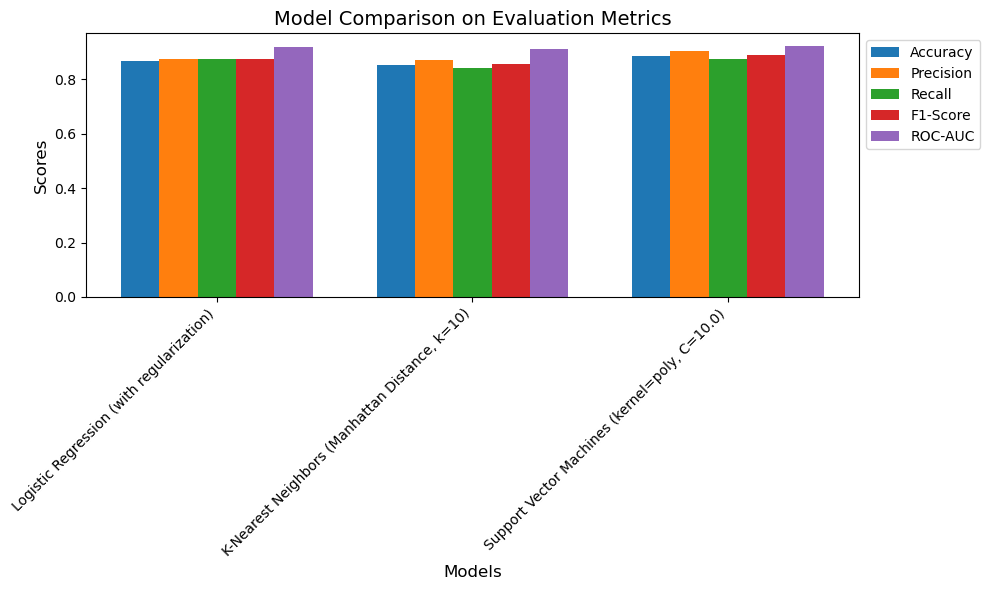

In [37]:
# Data for the models and metrics
models = ['Logistic Regression (with regularization)', 
          'K-Nearest Neighbors (Manhattan Distance, k=10)', 
          'Support Vector Machines (kernel=poly, C=10.0)']
accuracy = [0.868, 0.852, 0.885]
precision = [0.875, 0.870, 0.903]
recall = [0.875, 0.843, 0.875]
f1_score = [0.875, 0.857, 0.888]
roc_auc = [0.92, 0.913, 0.923]

# Prepare the data for the grouped bar chart
metrics = np.array([accuracy, precision, recall, f1_score, roc_auc])
metrics = metrics.T  # Transpose to have rows represent models

# Bar chart properties
bar_width = 0.15
index = np.arange(len(models))  # The x locations for the groups

fig, ax = plt.subplots(figsize=(10, 6))

# Create the bars for each metric
ax.bar(index, metrics[:, 0], bar_width, label='Accuracy')
ax.bar(index + bar_width, metrics[:, 1], bar_width, label='Precision')
ax.bar(index + 2 * bar_width, metrics[:, 2], bar_width, label='Recall')
ax.bar(index + 3 * bar_width, metrics[:, 3], bar_width, label='F1-Score')
ax.bar(index + 4 * bar_width, metrics[:, 4], bar_width, label='ROC-AUC')

# Adding labels and title
ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Scores', fontsize=12)
ax.set_title('Model Comparison on Evaluation Metrics', fontsize=14)
ax.set_xticks(index + 2 * bar_width)
ax.set_xticklabels(models, rotation=45, ha='right')

# Minimized legend
ax.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

# Display the chart
plt.tight_layout()
plt.show()
